In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_visits = pd.read_csv('MSNBC visits per page per user.csv')
df_category_freq = pd.read_csv('MSNBC visits per page.csv')
exploded_df = pd.read_csv('MSNBC network edge weights calc.csv')
df_entry_freq = pd.read_csv('MSNBC first visited pages per user.csv')

In [63]:
#normalize node weights

category_df_norm = df_category_freq
visit_total = category_df_norm['site_visit_counts'].sum()
category_df_norm['normalized_site_visit_counts']= category_df_norm['site_visit_counts']\
.apply(lambda x: round(float(x)/visit_total , 10)) 

category_df_norm.columns = ['site_id', 'site_description', 'site_visit_counts', 'normalized_site_visit_counts']

category_df_norm

,site_id,site_description,site_visit_counts,normalized_site_visit_counts
0,1,frontpage,940469,0.200151
1,2,news,452387,0.096277
2,3,tech,207479,0.044156
3,4,local,386217,0.082195
4,5,opinion,151409,0.032223
5,6,on-air,414928,0.088305
6,7,misc,305615,0.065041
7,8,weather,439398,0.093513
8,9,msn-news,196614,0.041844
9,10,health,131760,0.028041


In [64]:
#Generate edge weight table

exploded_df['edge_path'] = list(zip(exploded_df.site_id, exploded_df.next_sequence))
exploded_df['edge_path_desc'] = list(zip(exploded_df.site_description, exploded_df.next_sequence_desc))

#calculate edge weights

weights_df =exploded_df['edge_path_desc'].value_counts().reset_index()
weights_df.columns = ['edge_path', 'edge_path_counts']

weights_df

,edge_path,edge_path_counts
0,"(frontpage, frontpage)",627288
1,"(weather, weather)",343783
2,"(news, news)",277101
3,"(sports, sports)",276742
4,"(local, local)",264498
...,...,...
165,"(msn-news, bbs)",31
166,"(tech, bbs)",29
167,"(local, bbs)",28
168,"(msn-sports, travel)",27


In [65]:
#Generate normalized edge weight table

weights_df_norm = weights_df
col_total = weights_df_norm['edge_path_counts'].sum()
weights_df_norm['normalized_edge_path']= weights_df_norm['edge_path_counts']\
.apply(lambda x: round(float(x)/col_total , 10)) 

weights_df_norm.columns = ['edge_path', 'edge_path_counts', 'normalized_edge_path']

weights_df_norm

,edge_path,edge_path_counts,normalized_edge_path
0,"(frontpage, frontpage)",627288,0.133500
1,"(weather, weather)",343783,0.073164
2,"(news, news)",277101,0.058973
3,"(sports, sports)",276742,0.058896
4,"(local, local)",264498,0.056291
...,...,...,...
165,"(msn-news, bbs)",31,0.000007
166,"(tech, bbs)",29,0.000006
167,"(local, bbs)",28,0.000006
168,"(msn-sports, travel)",27,0.000006


In [66]:
# Generate NetworkX graph with all the nodes and nan
# NetworkX version 2.3

import networkx as nx

G = nx.Graph()

node_name = df_category_freq['site_description']
node_weight = df_category_freq['site_visit_counts']

nw_dict1 = dict(zip(node_name, node_weight))

edges = weights_df['edge_path']
edge_weights = weights_df['edge_path_counts']

ew_dict1 = dict(zip(edges, edge_weights))

for nn in node_name:
    G.add_node(nn, weight=nw_dict1[nn])

for ew in ew_dict1:
    G.add_edge(ew[0], ew[1], weight = ew_dict1[ew])
    
print(G.nodes)
print(G.node['frontpage']['weight'])
print(G.edges)
print(nx.adjacency_matrix(G).todense())
sorted(nx.connected_components(G), key = len, reverse=True)

['frontpage', 'news', 'tech', 'local', 'opinion', 'on-air', 'misc', 'weather', 'msn-news', 'health', 'living', 'business', 'msn-sports', 'sports', 'summary', 'bbs', 'travel', nan]
940469
[('frontpage', 'frontpage'), ('frontpage', nan), ('frontpage', 'news'), ('frontpage', 'local'), ('frontpage', 'on-air'), ('frontpage', 'tech'), ('frontpage', 'business'), ('frontpage', 'sports'), ('frontpage', 'living'), ('frontpage', 'misc'), ('frontpage', 'health'), ('frontpage', 'opinion'), ('frontpage', 'weather'), ('frontpage', 'msn-news'), ('frontpage', 'msn-sports'), ('frontpage', 'summary'), ('frontpage', 'travel'), ('frontpage', 'bbs'), ('news', 'news'), ('news', nan), ('news', 'tech'), ('news', 'local'), ('news', 'on-air'), ('news', 'business'), ('news', 'sports'), ('news', 'weather'), ('news', 'health'), ('news', 'living'), ('news', 'misc'), ('news', 'opinion'), ('news', 'msn-news'), ('news', 'summary'), ('news', 'travel'), ('news', 'msn-sports'), ('news', 'bbs'), ('tech', 'tech'), ('tech', 

[{'bbs',
  'business',
  'frontpage',
  'health',
  'living',
  'local',
  'misc',
  'msn-news',
  'msn-sports',
  nan,
  'news',
  'on-air',
  'opinion',
  'sports',
  'summary',
  'tech',
  'travel',
  'weather'}]

In [87]:
#remove nan as a node
#use normalized edge weights and node weights
#Undirected graph

G3 = nx.Graph()

node_name = df_category_freq['site_description']
node_weight = category_df_norm['normalized_site_visit_counts']

nw_dict = dict(zip(node_name, node_weight))

edges = weights_df['edge_path']

#nan has a float data type
edges_clean = [e for e in edges if isinstance(e[1], str)]
edge_clean_weights = weights_df[weights_df['edge_path'].isin(edges_clean)]['normalized_edge_path']

ew_dict = dict(zip(edges_clean, edge_clean_weights))

for nn in node_name:
    G3.add_node(nn, weight=nw_dict[nn])

for ew in ew_dict:
    G3.add_edge(ew[0], ew[1], weight = ew_dict[ew])

print(G3.nodes)
#node weights
print(G3.degree(weight = 'weight'))
print(G3.edges)
print(nx.adjacency_matrix(G3).todense())

['frontpage', 'news', 'tech', 'local', 'opinion', 'on-air', 'misc', 'weather', 'msn-news', 'health', 'living', 'business', 'msn-sports', 'sports', 'summary', 'bbs', 'travel']
[('frontpage', 0.31029706790000006), ('news', 0.15535092629999997), ('tech', 0.057252988800000015), ('local', 0.14014425800000002), ('opinion', 0.061377238400000006), ('on-air', 0.1163990164), ('misc', 0.1206486175), ('weather', 0.15774430620000002), ('msn-news', 0.06135638210000001), ('health', 0.047294050099999985), ('living', 0.0312744077), ('business', 0.08355143890000002), ('msn-sports', 0.0690696379), ('sports', 0.13484396250000003), ('summary', 0.017148442899999998), ('bbs', 0.0102645489), ('travel', 0.004675455100000001)]
[('frontpage', 'frontpage'), ('frontpage', 'news'), ('frontpage', 'local'), ('frontpage', 'on-air'), ('frontpage', 'tech'), ('frontpage', 'business'), ('frontpage', 'sports'), ('frontpage', 'living'), ('frontpage', 'misc'), ('frontpage', 'health'), ('frontpage', 'opinion'), ('frontpage', 

In [88]:
sorted(nx.connected_components(G3), key = len, reverse=True)

[{'bbs',
  'business',
  'frontpage',
  'health',
  'living',
  'local',
  'misc',
  'msn-news',
  'msn-sports',
  'news',
  'on-air',
  'opinion',
  'sports',
  'summary',
  'tech',
  'travel',
  'weather'}]

In [73]:
#remove nan as a node
#use normalized edge weights and node weights
#Directed graph

G6 = nx.DiGraph()

node_name = df_category_freq['site_description']
node_weight = category_df_norm['normalized_site_visit_counts']

nw_dict = dict(zip(node_name, node_weight))

edges = weights_df['edge_path']

#nan has a float data type
edges_clean = [e for e in edges if isinstance(e[1], str)]
edge_clean_weights = weights_df[weights_df['edge_path'].isin(edges_clean)]['normalized_edge_path']

ew_dict = dict(zip(edges_clean, edge_clean_weights))

for nn in node_name:
    G6.add_node(nn, weight=nw_dict[nn])

for ew in ew_dict:
    G6.add_edge(ew[0], ew[1], weight = ew_dict[ew])

print(G6.nodes)
#node weights
print(G6.degree(weight = 'weight'))
print(G6.edges)
print(nx.adjacency_matrix(G6).todense())

['frontpage', 'news', 'tech', 'local', 'opinion', 'on-air', 'misc', 'weather', 'msn-news', 'health', 'living', 'business', 'msn-sports', 'sports', 'summary', 'bbs', 'travel']
[('frontpage', 0.31029706790000006), ('news', 0.15535092629999997), ('tech', 0.057252988799999995), ('local', 0.14014425800000002), ('opinion', 0.061377238400000006), ('on-air', 0.1163990164), ('misc', 0.1206486175), ('weather', 0.15774430620000002), ('msn-news', 0.061356382099999995), ('health', 0.047294050099999985), ('living', 0.0312744077), ('business', 0.08355143890000002), ('msn-sports', 0.0690696379), ('sports', 0.13484396250000003), ('summary', 0.0171484429), ('bbs', 0.0102645489), ('travel', 0.004675455100000001)]
[('frontpage', 'frontpage'), ('frontpage', 'news'), ('frontpage', 'local'), ('frontpage', 'on-air'), ('frontpage', 'tech'), ('frontpage', 'business'), ('frontpage', 'sports'), ('frontpage', 'living'), ('frontpage', 'misc'), ('frontpage', 'health'), ('frontpage', 'opinion'), ('frontpage', 'weathe

<Figure size 1440x1440 with 0 Axes>

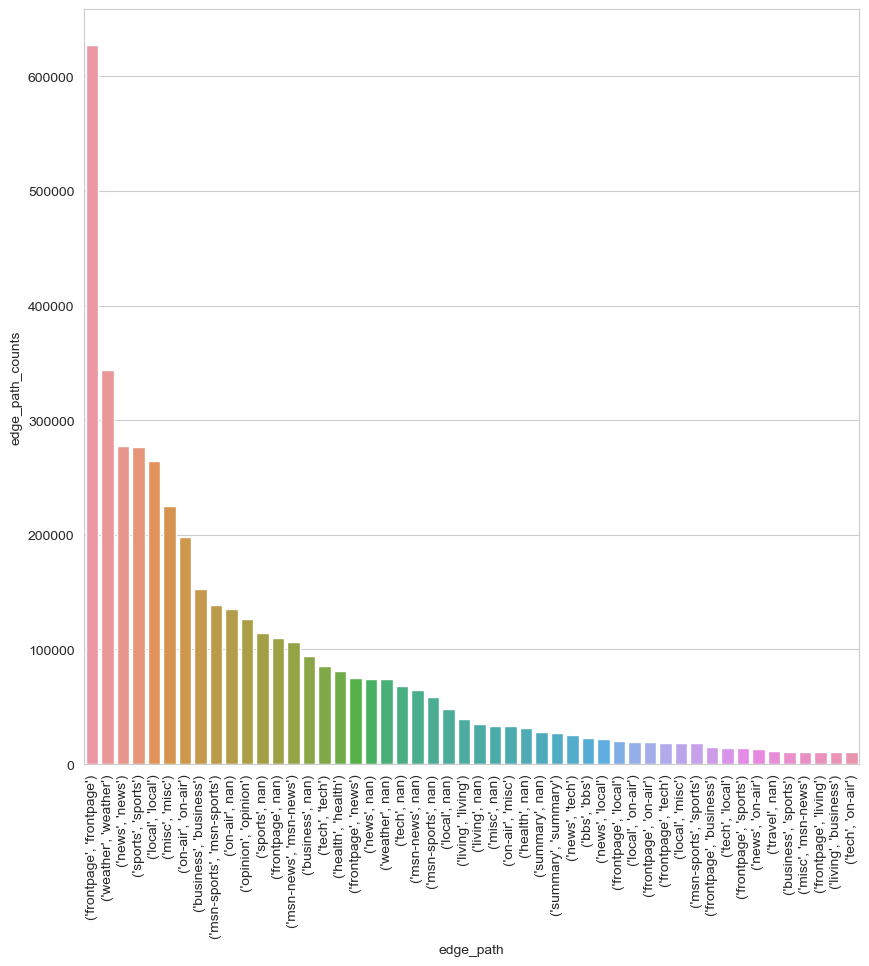

In [49]:
#Navigation path frequency (later used as Edge Weights)

weights_df_graph = weights_df
weights_df_graph['edge_path'] =  weights_df_graph['edge_path'].astype(str)

top_50 = weights_df_graph.head(50)
sns.set_style('whitegrid')

plt.clf()
fig , ax = plt.subplots(1,1, figsize = (10, 10), dpi = 100)
sns.barplot(x = 'edge_path', y = 'edge_path_counts', data = top_50)
raw_labels = list(top_50['edge_path'])

ax.set_xticklabels(raw_labels, rotation=90)
plt.show()

<Figure size 1440x1440 with 0 Axes>

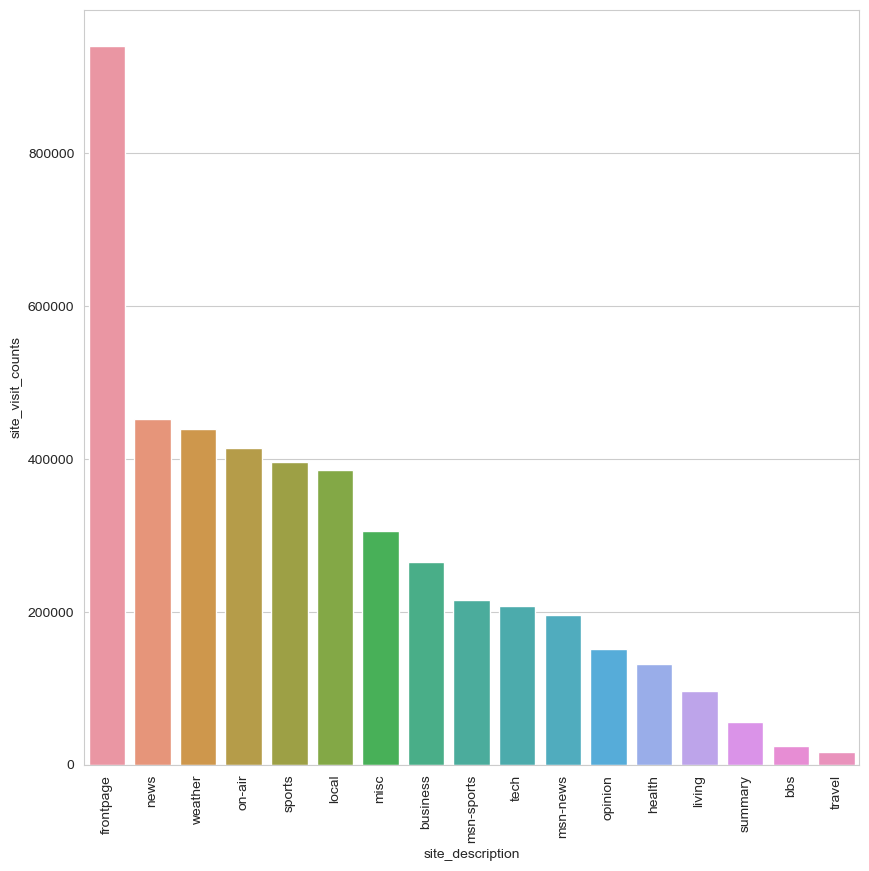

In [50]:
#Page access frequency (later used as Node Weights)

plt.clf()

df_category_freq_sorted = df_category_freq.sort_values(by=['site_visit_counts'], ascending=False)

fig, ax = plt.subplots(1,1, figsize = (10, 10), dpi = 100)
sns.barplot(x = 'site_description', y = 'site_visit_counts', data = df_category_freq_sorted)
ax.set_xticklabels(df_category_freq_sorted['site_description'], rotation=90)

plt.show()

<Figure size 1440x1440 with 0 Axes>

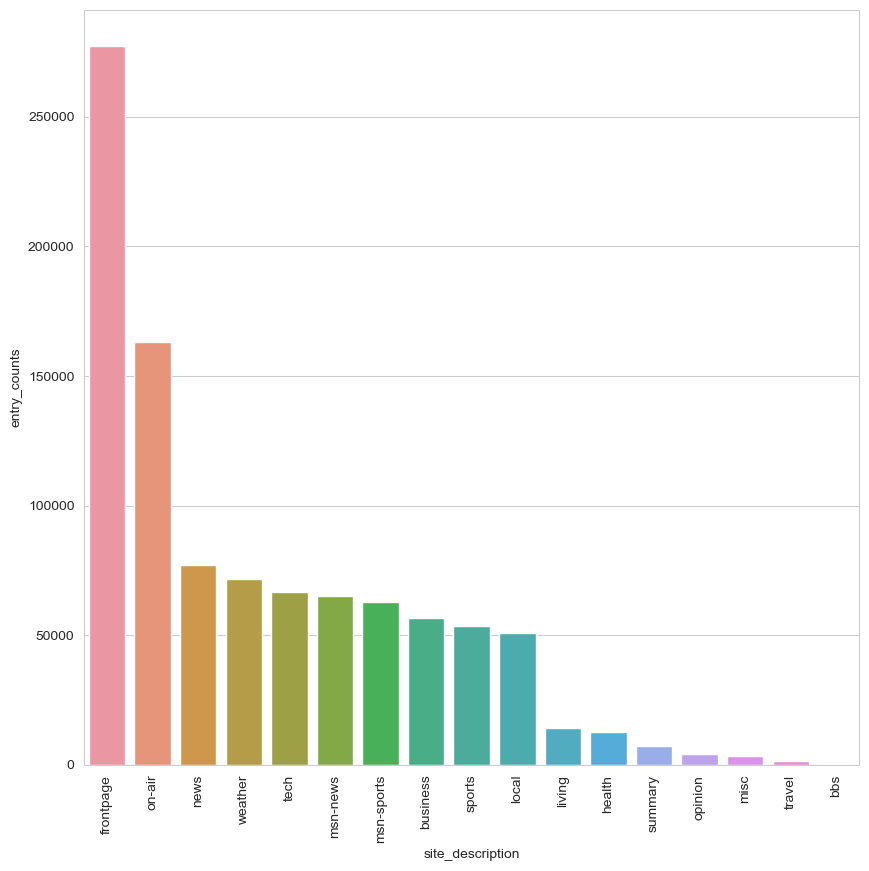

In [51]:
#entry site frequency

plt.clf()

fig, ax = plt.subplots(1,1, figsize = (10, 10), dpi = 100)
sns.barplot(x = 'site_description', y = 'entry_counts', data = df_entry_freq)
ax.set_xticklabels(df_entry_freq['site_description'], rotation=90)

plt.show()


C:\Users\v-wumei\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


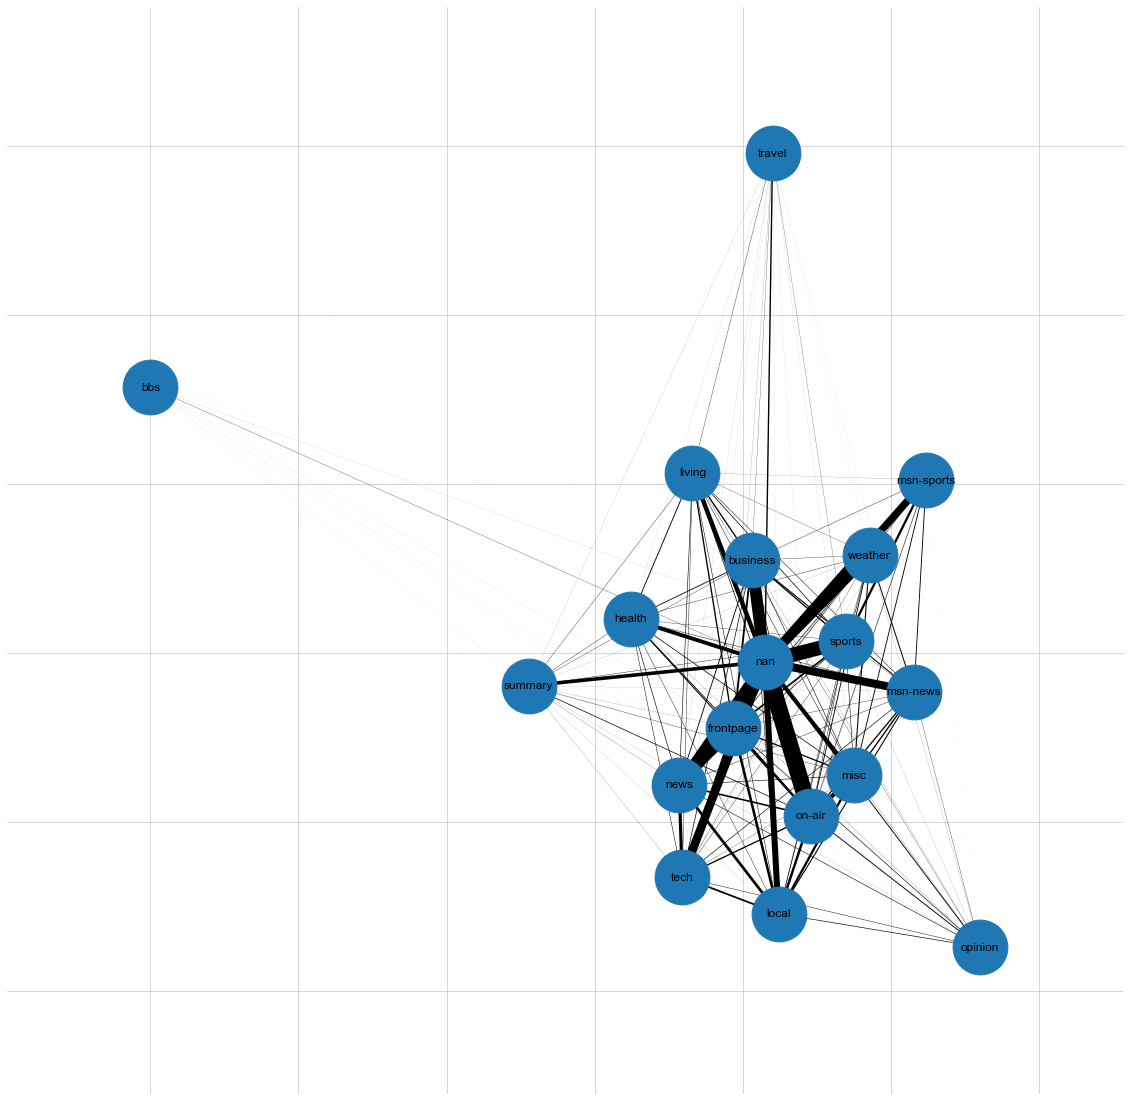

In [52]:
#graph G (containing nan node) with edge weights

plt.rcParams.update({
    'figure.figsize': (20, 20),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

fig, ax = plt.subplots(1,1)
weights = [d['weight']/8000 for s, t, d in G.edges(data=True)]
graph_pos = nx.spring_layout(G, k=0.6)
nx.draw_networkx(G, graph_pos, width=weights, node_size=3000)
ax.margins(0.15, 0.15)

C:\Users\v-wumei\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


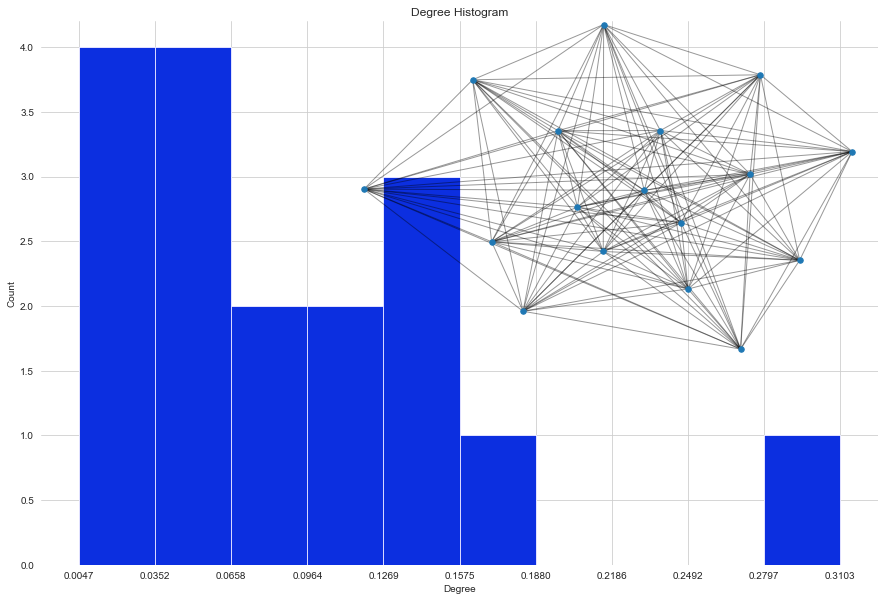

In [90]:
#Degree Distribution Histogram
#undirected graph
#no nan node

degree_sequence = sorted([d for n, d in G3.degree(weight='weight')], reverse=True) 

plt.rcParams.update({
    'figure.figsize': (15,10),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

fig, ax = plt.subplots()
plt.hist(degree_sequence)
counts, bins, patches = ax.hist(degree_sequence, color='b', alpha=0.6)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks(bins)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G3.subgraph(sorted(nx.connected_components(G3), key=len, reverse=True)[0])
pos = nx.spring_layout(G3)
plt.axis('off')
nx.draw_networkx_nodes(G3, pos, node_size=30)
nx.draw_networkx_edges(G3, pos, alpha=0.4)

plt.show()

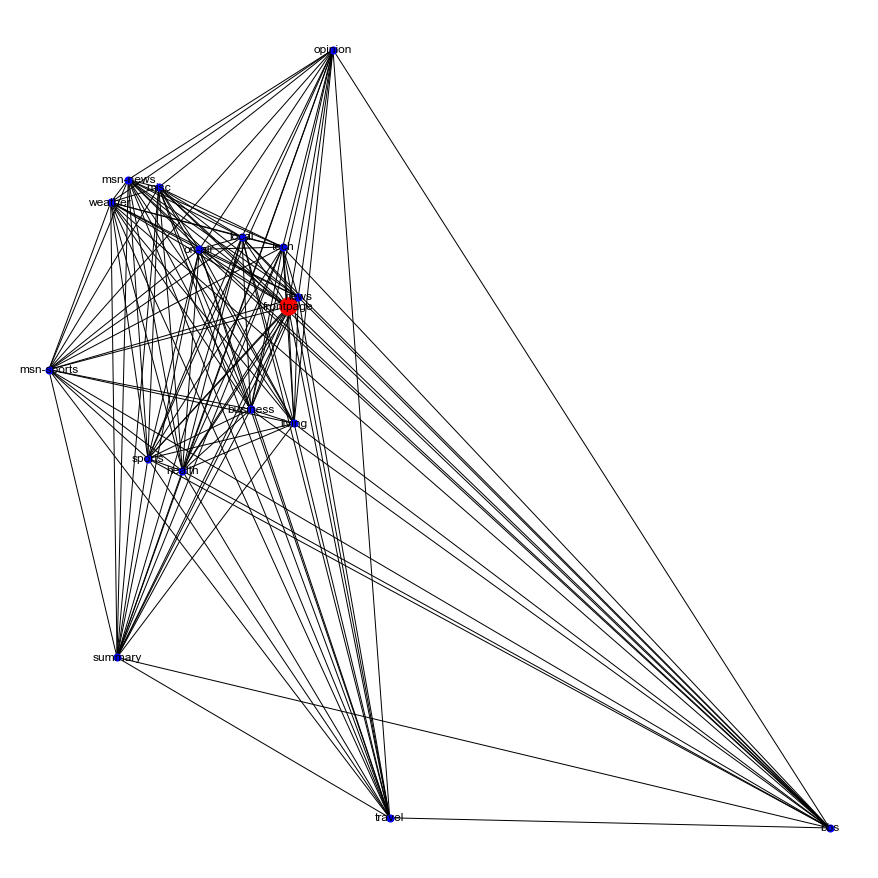

In [91]:
#Hub - frontpage

plt.rcParams.update({
    'figure.figsize': (12,12),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

from operator import itemgetter

# find node with largest degree
node_and_degree = G3.degree(weight='weight')
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego = nx.ego_graph(G2, largest_hub)
# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=True)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='r', with_labels=True)
plt.show()

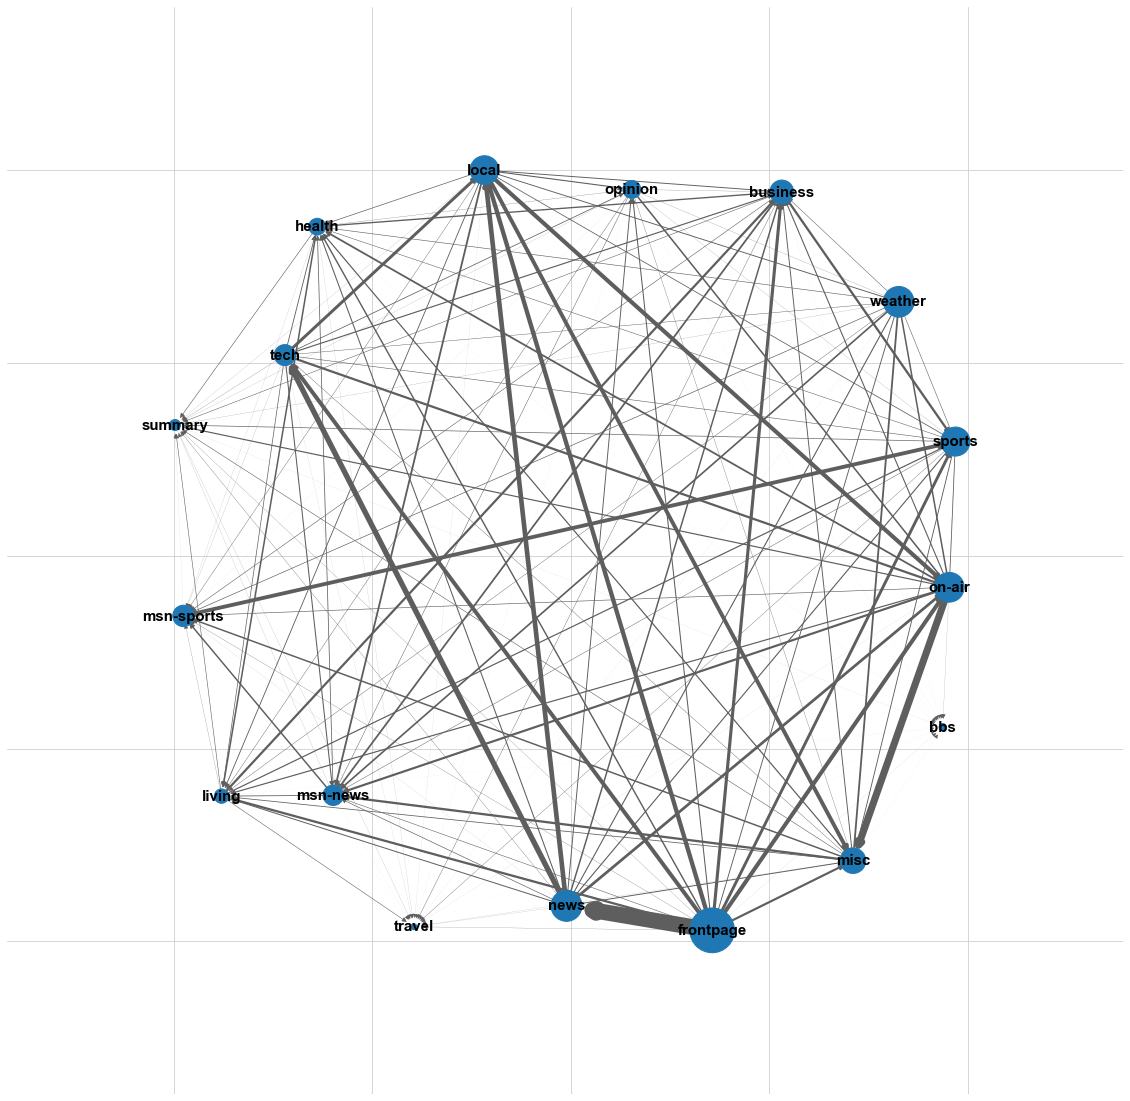

In [84]:
#spring layout
#directed graph with node weights and edge weights 
#no nan
#edge weights and node weights normalized

plt.rcParams.update({
    'figure.figsize': (20, 20),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

fig, ax = plt.subplots(1,1)
node_weight = [G6.node[n]['weight']*10000 for n in G6.node]
edge_weights = [d['weight']*1000 for s, t, d in G6.edges(data=True)]
graph_pos = nx.spring_layout(G6, k=0.6)
edges = nx.draw_networkx_edges(G6, graph_pos, edge_color='#5e5e5e', width=edge_weights)
nodes = nx.draw_networkx_nodes(G6, graph_pos, node_size=node_weight)
labels = nx.draw_networkx_labels(G6, graph_pos, font_size=15, font_weight='bold')
ax.margins(0.15, 0.15)

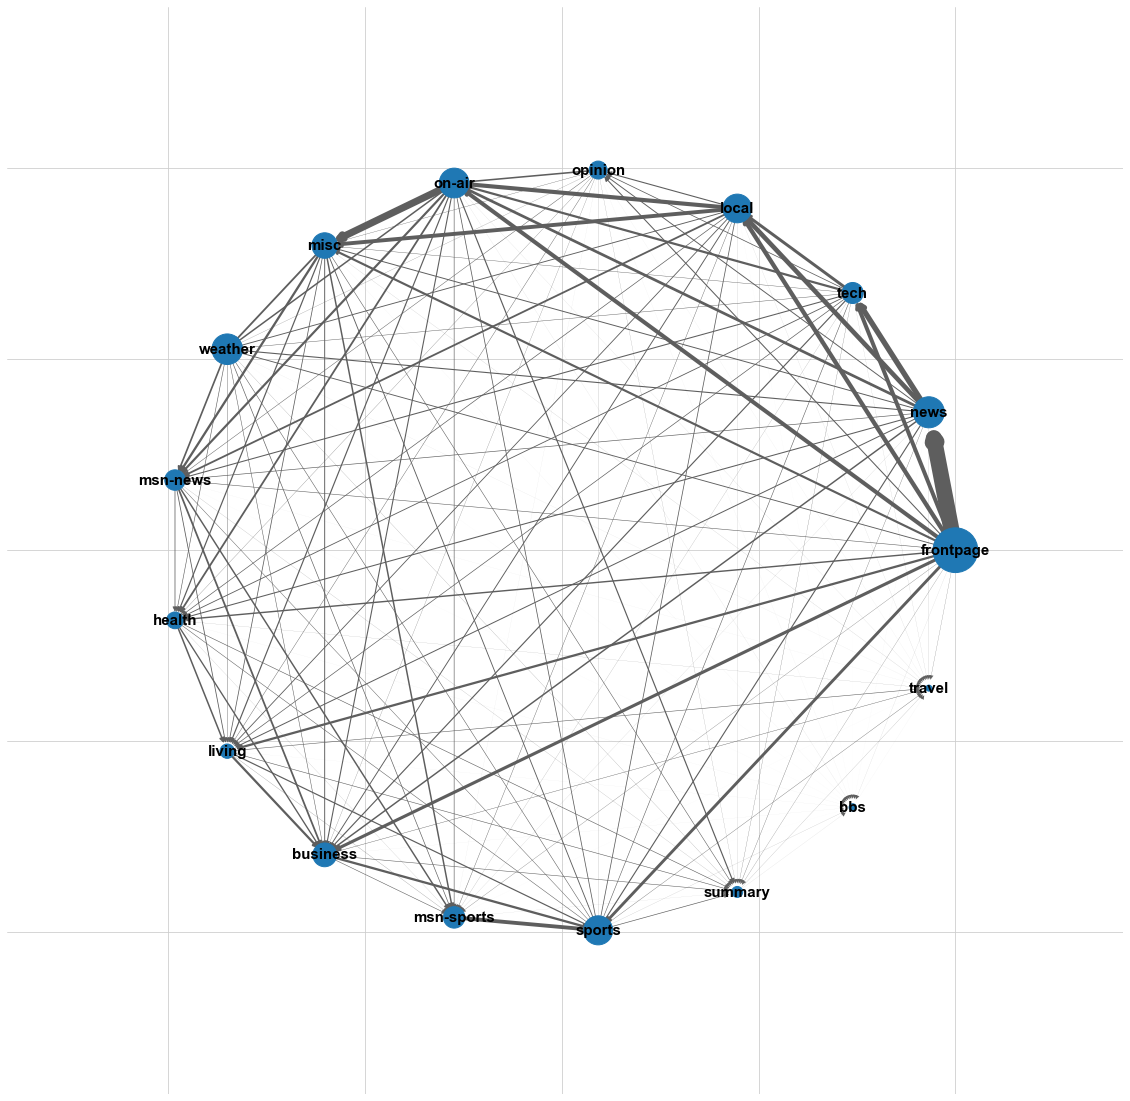

In [85]:
#Circular/shell layout
#directed graph with node weights and edge weights 
#no nan
#edge weights and node weights normalized

plt.rcParams.update({
    'figure.figsize': (20, 20),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

fig, ax = plt.subplots(1,1)
node_weight = [G6.node[n]['weight']*10000 for n in G6.node]
edge_weights = [d['weight']*1000 for s, t, d in G6.edges(data=True)]
graph_pos = nx.circular_layout(G6)
edges = nx.draw_networkx_edges(G6, graph_pos, edge_color='#5e5e5e', width=edge_weights)
nodes = nx.draw_networkx_nodes(G6, graph_pos, node_size=node_weight)
labels = nx.draw_networkx_labels(G6, graph_pos, font_size=15, font_weight='bold')

ax.margins(0.15, 0.15)

In [81]:
nx.write_graphml(G6, "G6.graphml")
nx.write_graphml(G6, "G6.xml")
nx.write_gml(G6, 'G6.gml')